# Spaxel stacking and masking demo
This notebook should illistrate the process of spectra masking and stacking, as a follow up after the 26th Aug meeting. <br>
Previously, the initial fit did not involve masking from PCA-determined spaxel labels, so those masks were only the product of two elements: H alpha-calculated qualmasks directly pulled from MaNGA cubes and SNR>15, where SNR of a spaxel is calculated via the mean among all pixels of that spaxel. The non-binned raw DRP fluxes were also used. <br>
Other than the introduction of the PCA-determined spaxel labels as a masking criteria, I also noticed that the qualmasks from the PCA fits files are differnt from what I achieved previously directly from H alpha maps from MaNGA. My calculation is:
```
nocov = ha_qual.pixmask.get_mask('NOCOV')
lowcov = ha_qual.pixmask.get_mask('LOWCOV')
donotuse = ha_qual.pixmask.get_mask('DONOTUSE')
deadfiber = ha_qual.pixmask.get_mask('DEADFIBER')
forestar = ha_qual.pixmask.get_mask('FORESTAR')
qualmask_ = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )
```
which turned out to include more spaxels than the PCA fits files' qualmask. Summing all of these together, I propose 5 different masking criteria combinations (binning means voronoi binning here):
1. unbinned SNR>15 + MaNGA Ha mask + PSB spaxel (uses unbinned fluxes)
2. unbinned SNR>15 + PCA Ha mask + PSB spaxel (uses unbinned fluxes)
3. binned SNR>15 + PCA Ha mask + PSB spaxel (uses voronoi-binned fluxes)
4. binned SNR>10 + PCA Ha mask + PSB spaxel (uses voronoi-binned fluxes)
5. PCA Ha mask + PSB spaxel (binned or not binned? either can be used here. Using unbinned for now for this notebook)

The reason why I am suggesting SNR limits at lower values is cause during early investigations, I realized the inclusion of PSB spaxel masking on top of the two already existing masks reduce the number of contributing spaxels for some PSBs (expecially the ringed PSBs) drastically. I also realized we can even ditch the whole concept of using SNR to select spaxels, and only go back to using SNR to make the cuts when doing spaxel-by-spaxel fitting. <br>
Also, perhaps since the PCA labelling were done on binned datacubes, it is best to only use binned cubes when stacking as well, not sure. <br>
The rest of this notebook will use one of the 15 PSBs as example to show comparisons between the original mask and these 5 combinations. Then, it will show plots of all PSBs as a whole.

In [40]:
import time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
import marvin
import pandas as pd
from PyAstronomy import pyasl

In [107]:
# skylines
lines_air_df = pd.read_fwf('../skylines.txt')
lines_vac = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=30]['wavelength'])
print(lines_vac)

def mask_sky(wave, masksize=10):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask, np.array([lines-masksize, lines+masksize]).T

[5578.8954556  6302.05104962 6365.54219491 8346.90679765 8401.48404869
 8401.48404869 8829.53629684 8888.29629305 8922.08573476 9315.90131855
 9326.32113949 9378.54917978 9442.25973032 9479.49541313 9793.80124247
 9874.8545013  9917.49585452 9949.24175613 9959.32848922]


In [108]:
# setup functions
class galaxy:

    def __init__(self, plateifu):
        # first get all relevent cubes and masks and fits files and PCA labels
        self.DRPcube = marvin.tools.Cube(plateifu)
        if self.DRPcube.mode == 'remote':
            self.DRPcube.download()
        self.DAPcube = marvin.tools.ModelCube(plateifu)
        if self.DAPcube.mode == 'remote':
            self.DAPcube.download()
        self.maps = marvin.tools.Maps(plateifu)
        if self.maps.mode == 'remote':
            self.maps.download()
        ha_qual = self.maps['emline_gflux_ha_6564']
        PCA_file = "./from_colaborators/ALMA_PSBs_PCAmaps/manga-"+plateifu+"_PCA.fits"
        self.PCA_fits = fits.open(PCA_file)
        self.PCA_qualmask = 1-self.PCA_fits[7].data
        self.PSB_mask = self.PCA_fits[10].data==5
        
        # get Ha qualmask from marvin
        nocov = ha_qual.pixmask.get_mask('NOCOV')
        lowcov = ha_qual.pixmask.get_mask('LOWCOV')
        donotuse = ha_qual.pixmask.get_mask('DONOTUSE')
        deadfiber = ha_qual.pixmask.get_mask('DEADFIBER')
        forestar = ha_qual.pixmask.get_mask('FORESTAR')
        qualmask_ = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )
        self.qualmask = (qualmask_==0)
        
        # Milky way reddening correction
        self.cube_redcorr = self.DAPcube._redcorr
        cube_redcorr_ = self.cube_redcorr[:,np.newaxis,np.newaxis]
        self.corrected_flux = self.DRPcube.flux.value*cube_redcorr_
        self.corrected_ivar = self.DRPcube.flux.ivar/cube_redcorr_**2
        
        self.binned_corrected_flux = self.DAPcube.binned_flux.value*cube_redcorr_
        self.binned_corrected_ivar = self.DAPcube.binned_flux.ivar/cube_redcorr_**2
        
        # SNR calculations
        self.snr = np.mean(self.DRPcube.flux.snr,axis=0)
        self.binned_snr = np.mean(self.DAPcube.binned_flux.snr,axis=0)
        
    def stack(self, binned=False, SNR_threshold=None, qualmask_choice='default', vb=True):
        if binned:
            wavelength = self.DRPcube.flux.wavelength.value.copy()
            flux = self.binned_corrected_flux.copy()
            ivar = self.binned_corrected_ivar.copy()
            snr = self.binned_snr.copy()
        else:
            wavelength = self.DAPcube.binned_flux.wavelength.value.copy()
            flux = self.corrected_flux.copy()
            ivar = self.corrected_ivar.copy()
            snr = self.snr.copy()
            
        if qualmask_choice == 'default':
            qualmask = self.qualmask.copy()
        elif qualmask_choice == 'PCA':
            qualmask = self.PCA_qualmask.copy()
        
        if SNR_threshold is None:
            self.combined_mask = qualmask * self.PSB_mask
        else:
            self.combined_mask = qualmask * self.PSB_mask * (snr>SNR_threshold)
        
        self.wavelength, self.spectrum, self.errors = self.stacking(wavelength, flux, ivar, self.combined_mask)
        
        if vb:
            o_mask = (self.qualmask & (self.snr>15))
            o_wavelength, o_spectrum, o_errors = self.stacking(self.DRPcube.flux.wavelength.value.copy(), 
                                                               self.binned_corrected_flux.copy(), 
                                                               self.binned_corrected_ivar.copy(), 
                                                               o_mask)
            print("previous masking stacked mean SNR:", np.mean(o_spectrum/o_errors))
            print("this masking stacked mean SNR:", np.mean(self.spectrum/self.errors))
            
            fig = plt.figure(figsize=[10,10])
            gs = matplotlib.gridspec.GridSpec(2,2)
            ax1 = plt.subplot(gs[0,0])
            ax2 = plt.subplot(gs[0,1])
            ax3 = plt.subplot(gs[1,:])
            
            ax1.imshow(o_mask, cmap='jet')
            ax1.set_title( r"previous masking")
            ax1.set_xlabel('x[pixel]')
            ax1.set_ylabel('y[pixel]')
            ax3.plot(o_wavelength, o_spectrum, label='previous')
            ax3.fill_between(o_wavelength, o_spectrum-o_errors, o_spectrum+o_errors)
            
            ax2.imshow(self.combined_mask, cmap='jet')
            ax2.set_title( r"this masking")
            ax2.set_xlabel('x[pixel]')
            ax2.set_ylabel('y[pixel]')
            ax3.plot(self.wavelength, self.spectrum, label='this')
            ax3.fill_between(self.wavelength, self.spectrum-self.errors, self.spectrum+self.errors)
            
            ax3.legend()
            ax3.set_xlim([min(self.wavelength),max(self.wavelength)])
            ax3.set_xlabel('wavelength[$\AA$]')
            ax3.set_ylabel('$f_\lambda \;/\; erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$')
            plt.show()
        
    def stacking(self, wavelength, flux, ivar, mask):
        masked_flux = mask * flux
        
        contribution_cube = np.zeros(np.shape(masked_flux))
        contribution_cube = mask * (1-(ivar==0))
        
        valid_pix_spectrum_cube = contribution_cube * masked_flux
        valid_pix_var_cube = np.where(contribution_cube==1, 1/ivar, 0)

        contribution_list = np.sum(contribution_cube, axis=(1,2))
        spectrum = np.sum(valid_pix_spectrum_cube, axis=(1,2)) \
                   *10**-17*max(contribution_list)/contribution_list
        errors = np.sqrt(np.sum(valid_pix_var_cube, axis=(1,2))) \
                 *10**-17*max(contribution_list)/contribution_list
        
        #dropping wavelength pixels that have summed error = 0
        zero_ind = np.where((errors==0)|(contribution_list==0)|(spectrum<=0))
        wavelength = np.delete(wavelength, zero_ind)
        spectrum = np.delete(spectrum, zero_ind)
        errors = np.delete(errors, zero_ind)
        
        return wavelength, spectrum, errors
        

Using the ringed PSB 8083-12703 for demonstration. The next cell plots its flux at 4559.3 anstroms, spaxel mean unbinned SNR, spaxel mean binned SNR, MaNGA H-alpha qualmask, PCA qualmask and the PCA spaxel labelling.

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: unclosed file <_io.FileIO name='./from_colaborators/ALMA_PSBs_PCAmaps/manga-8083-12703_PCA.fits' mode='rb' closefd=True> (ResourceWarning)


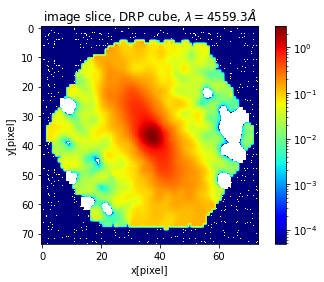

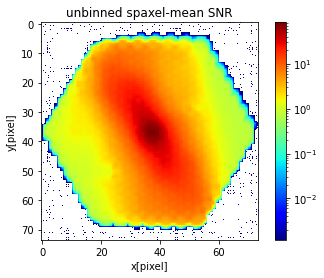

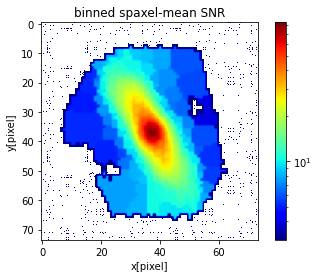

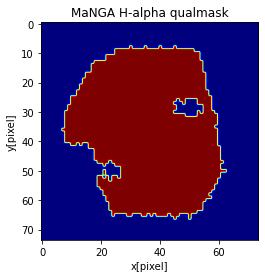

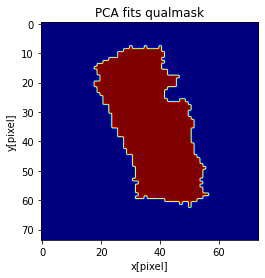

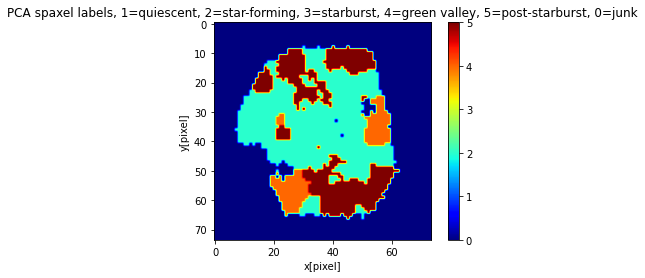

In [101]:
plateifu = '8083-12703'
gal = galaxy(plateifu)

#flux
idx = 1000
plt.imshow(gal.corrected_flux[idx], norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( r"image slice, DRP cube, $\lambda=%.1f\AA$" %gal.DRPcube.flux.wavelength[idx].value)
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#unbinned SNR
plt.imshow(gal.snr, norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( "unbinned spaxel-mean SNR")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#binned SNR
plt.imshow(gal.binned_snr, norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( "binned spaxel-mean SNR")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#MaNGA Ha qualmask
plt.imshow(gal.qualmask, cmap='jet')
plt.title( "MaNGA H-alpha qualmask")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#PCA fits qualmask
plt.imshow(gal.PCA_qualmask, cmap='jet')
plt.title( "PCA fits qualmask")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#PCA fits qualmask
temp_map = gal.PCA_fits[10].data.copy()
mask = gal.PCA_fits[10].data<0
temp_map[mask] = 0
plt.imshow(temp_map, cmap='jet')
plt.colorbar()
plt.title( "PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

### Option 1: unbinned SNR>15 + MaNGA Ha mask + PSB spaxel (uses unbinned fluxes)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 219.05931323310398


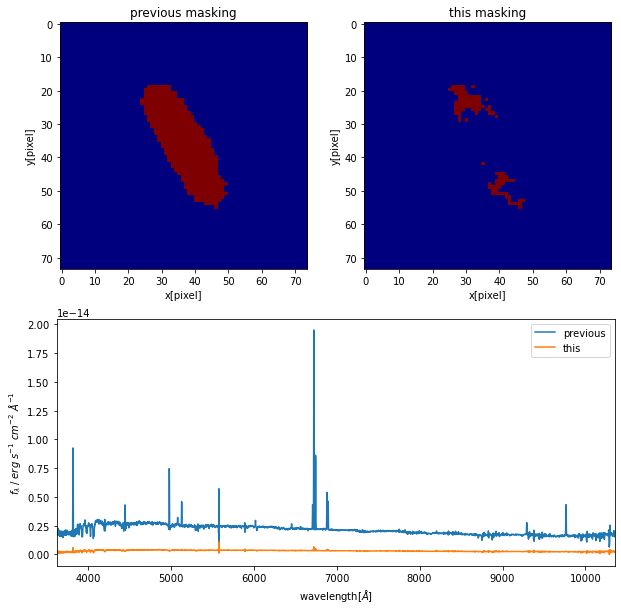

In [94]:
gal.stack(binned=False, SNR_threshold=15, qualmask_choice='default')

### Option 2: unbinned SNR>15 + PCA Ha mask + PSB spaxel (uses unbinned fluxes)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 219.05931323310398


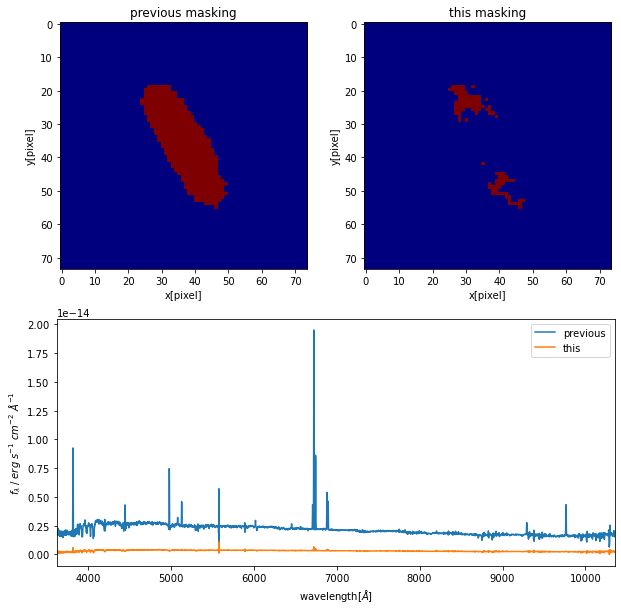

In [95]:
gal.stack(binned=False, SNR_threshold=15, qualmask_choice='PCA')

### Option 3: binned SNR>15 + PCA Ha mask + PSB spaxel (uses voronoi-binned fluxes)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 214.8683849550389


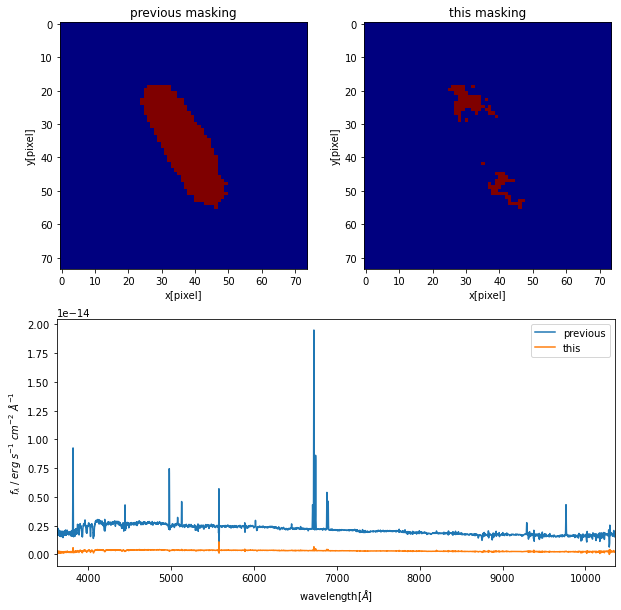

In [96]:
gal.stack(binned=True, SNR_threshold=15, qualmask_choice='PCA')

### Option 4: binned SNR>10 + PCA Ha mask + PSB spaxel (uses voronoi-binned fluxes)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 265.46544419255287


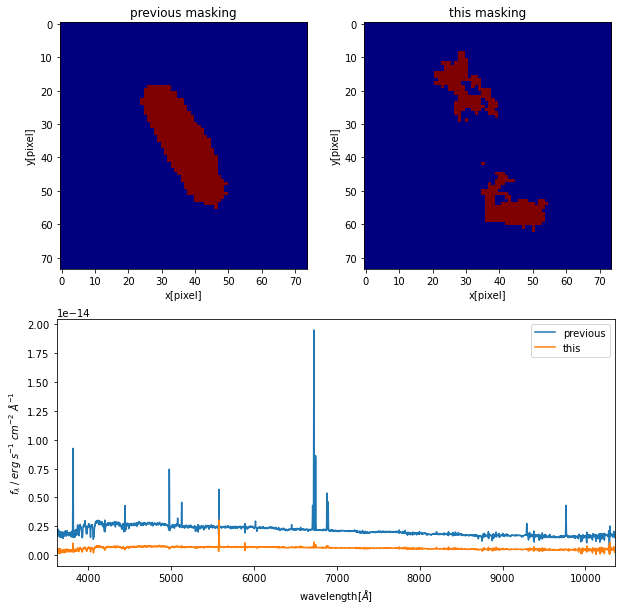

In [97]:
gal.stack(binned=True, SNR_threshold=10, qualmask_choice='PCA')

### Option 4: PCA Ha mask + PSB spaxel (using binned for now here)

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 274.5387685321849


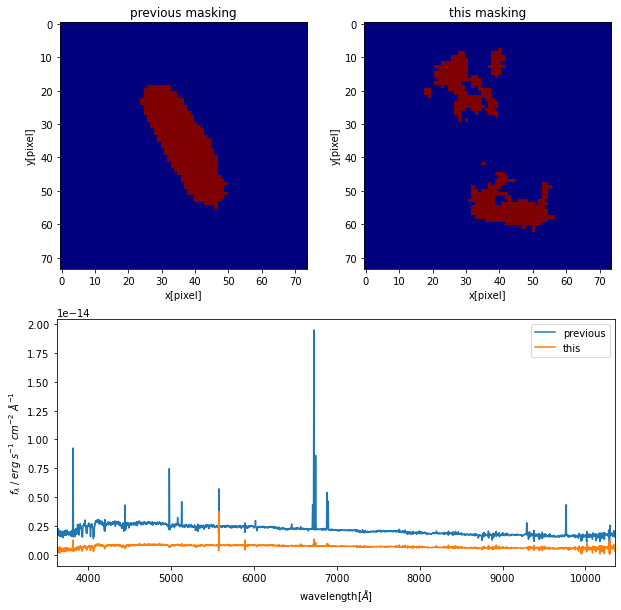

In [99]:
gal.stack(binned=True, SNR_threshold=None, qualmask_choice='PCA')

## Shifting to show all galaxies

In [100]:
targets = pd.read_fwf('PSBs_ALMAobs_sample.txt')
IDs = targets['plateifu']

galaxies = []
for plateifu in IDs:
    galaxies.append(galaxy(plateifu))

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch betw

[WARNING]: unclosed file <_io.FileIO name='./from_colaborators/ALMA_PSBs_PCAmaps/manga-8083-12703_PCA.fits' mode='rb' closefd=True> (ResourceWarning)


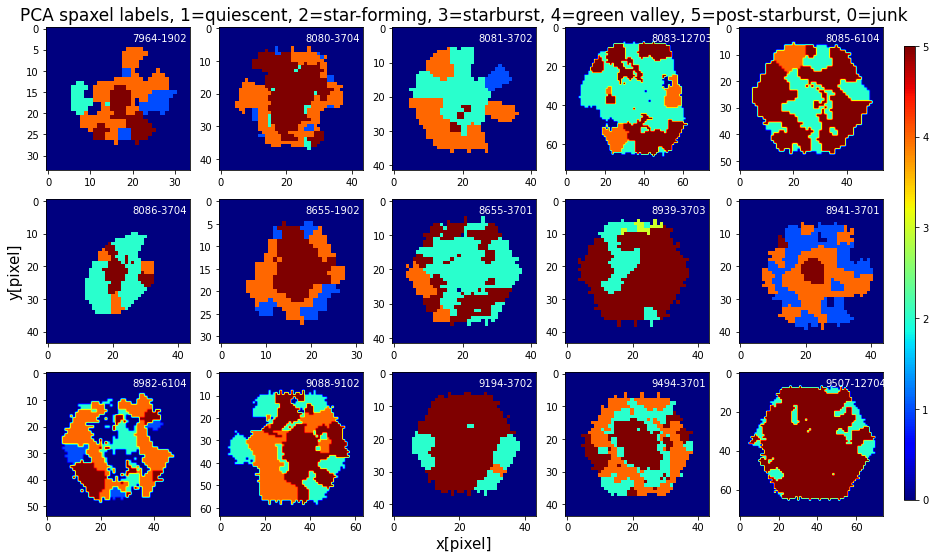

In [102]:
# PCA labelling
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    temp_map = gal.PCA_fits[10].data.copy()
    mask = gal.PCA_fits[10].data<0
    temp_map[mask] = 0
    im = axi.imshow(temp_map, cmap='jet')
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax[2,2].set_xlabel('x[pixel]', fontsize=15)
ax[1,0].set_ylabel('y[pixel]', fontsize=15)
ax[0,2].set_title('PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk'
                  , fontsize=17)
plt.show()

In [118]:
def plot_option(binned, SNR_threshold, qualmask_choice):
    fig, ax = plt.subplots(3,5, figsize=[15,9])
    for i,gal in enumerate(galaxies):
        axi = ax[i // 5, i % 5]
        gal.stack(binned=binned, SNR_threshold=SNR_threshold, qualmask_choice=qualmask_choice, vb=False)
        im = axi.imshow(gal.combined_mask, cmap='jet')
        axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    ax[2,2].set_xlabel('x[pixel]', fontsize=15)
    ax[1,0].set_ylabel('y[pixel]', fontsize=15)
    ax[0,2].set_title('PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk'
                      , fontsize=17)
    plt.show()

    fig, ax = plt.subplots(3,5, figsize=[15,9])
    for i,gal in enumerate(galaxies):
        axi = ax[i // 5, i % 5]
        spec_mask, mask_lims = mask_sky(gal.wavelength)
        spec_masked = np.delete(gal.spectrum, spec_mask)
        ylims = np.array([min(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000]),
                          max(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000])])*10**16
        ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]
        axi.plot(gal.wavelength, gal.spectrum*10**16, lw=0.3)
        #print(min(gal.errors), max(gal.errors), np.shape(gal.errors))
        axi.fill_between(gal.wavelength, gal.spectrum*10**16-gal.errors*10**16, gal.spectrum*10**16+gal.errors*10**16,
                        color='steelblue', alpha=0.2)
        for mask_lim_i in mask_lims:
            axi.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
        axi.set_xlim(3000,10000)
        axi.set_ylim([max([ylims[0],0]),ylims[1]])
        axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='black')

    ax[2,2].set_xlabel('wavelength[$\AA$]', fontsize=15)
    ax[1,0].set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
    ax[0,2].set_title('Stacked spectra', fontsize=17)
    plt.show()

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


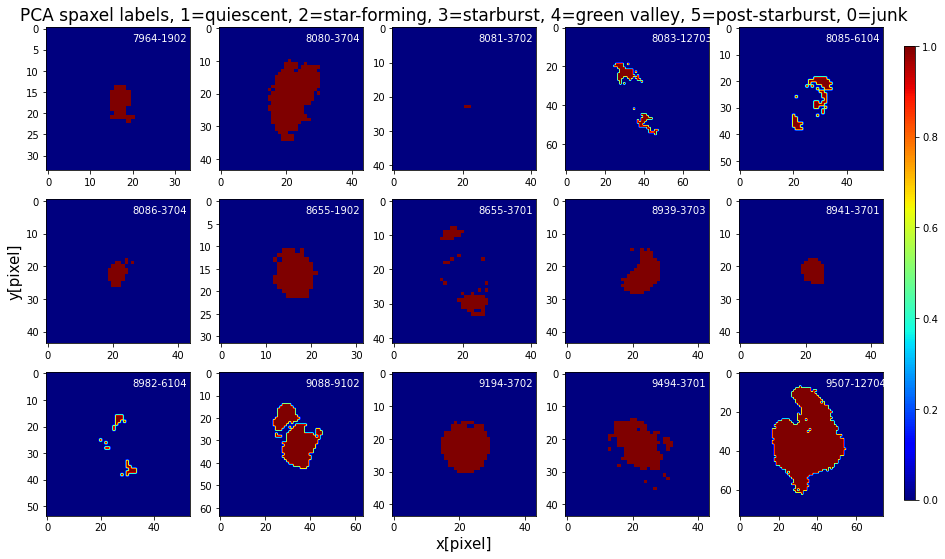

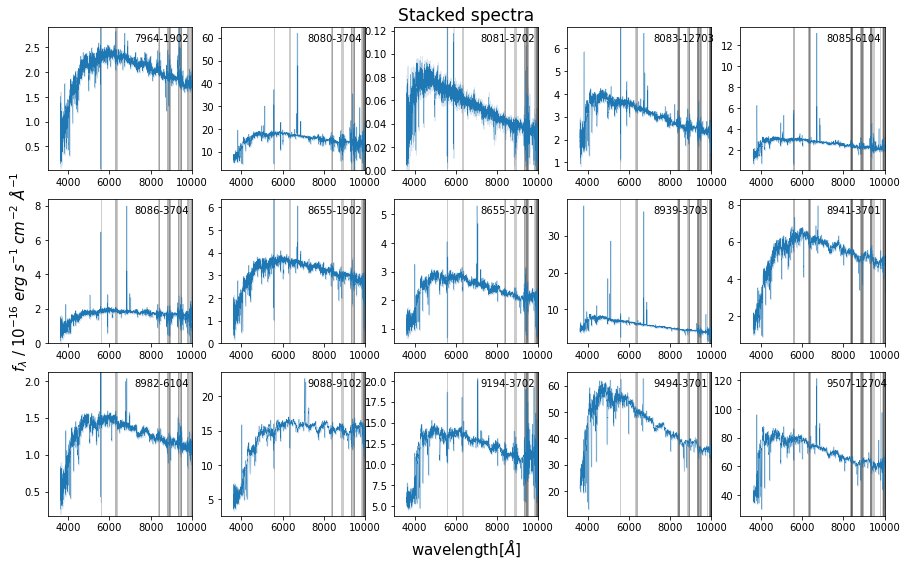

In [119]:
# option 1
plot_option(binned=False, SNR_threshold=15, qualmask_choice='default')

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


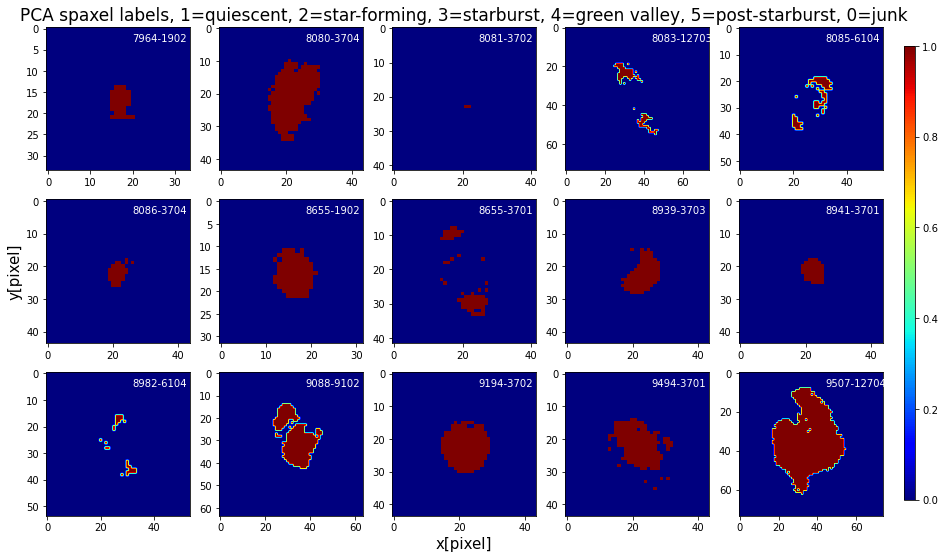

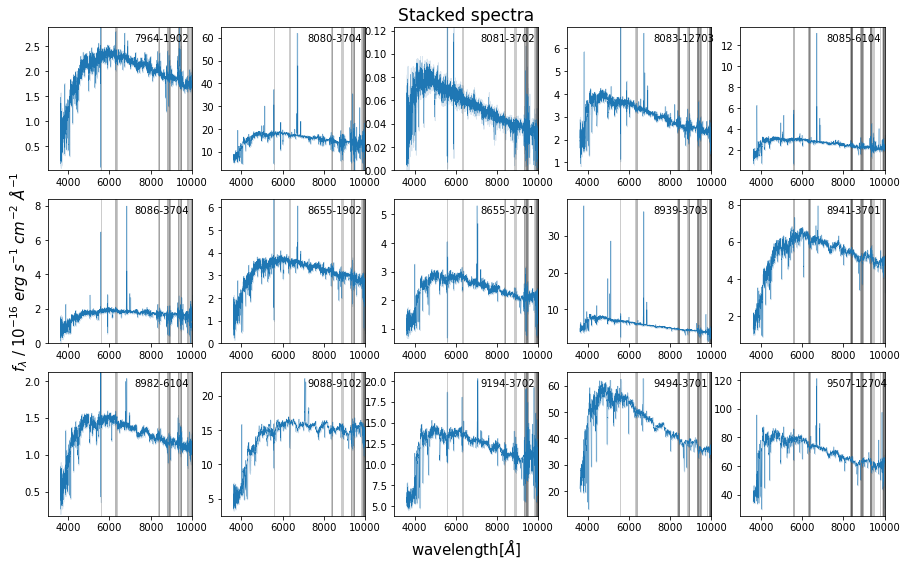

In [120]:
# option 2
plot_option(binned=False, SNR_threshold=15, qualmask_choice='PCA')

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


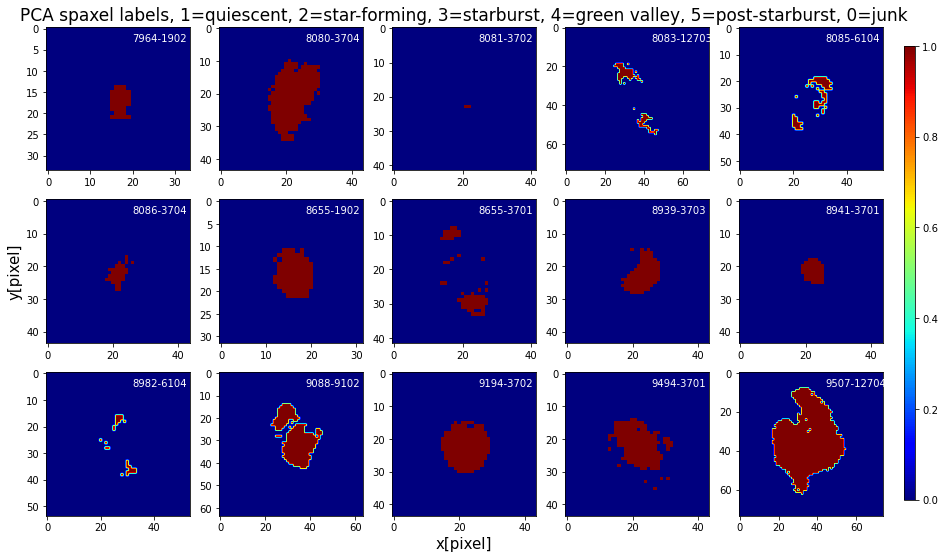

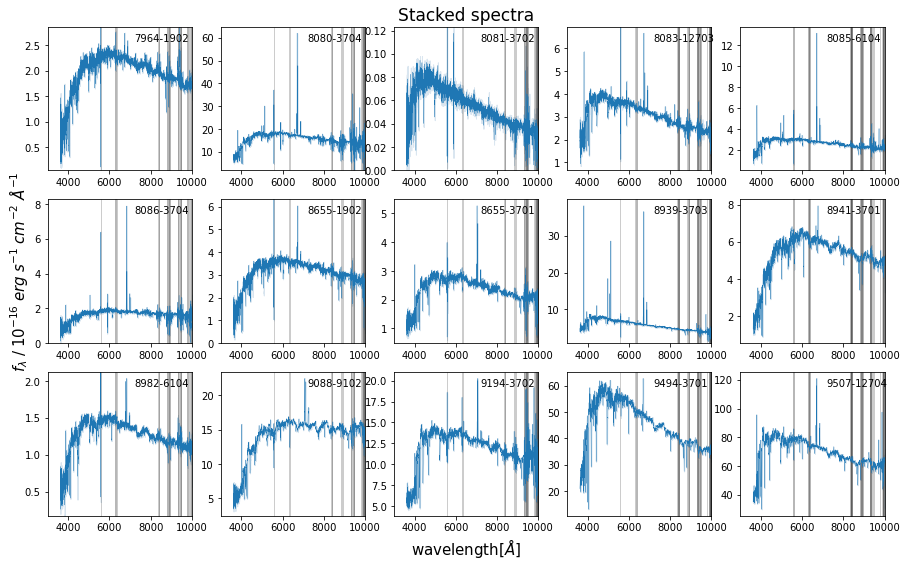

In [121]:
# option 3
plot_option(binned=True, SNR_threshold=15, qualmask_choice='PCA')

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


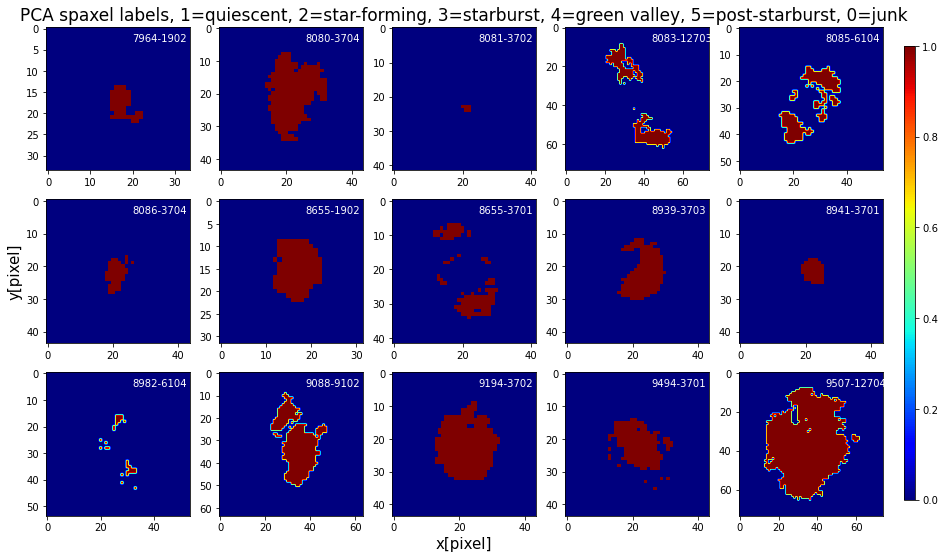

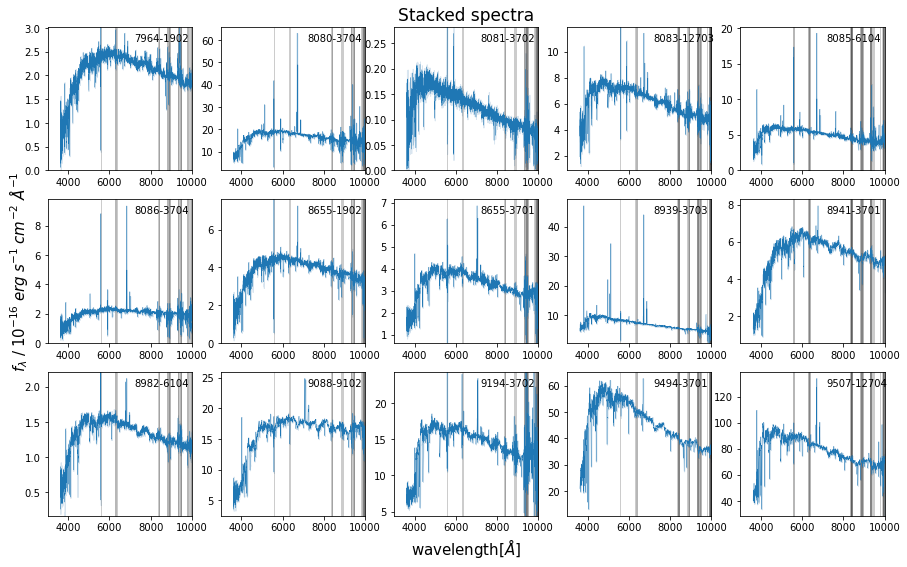

In [122]:
# option 4
plot_option(binned=True, SNR_threshold=10, qualmask_choice='PCA')

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


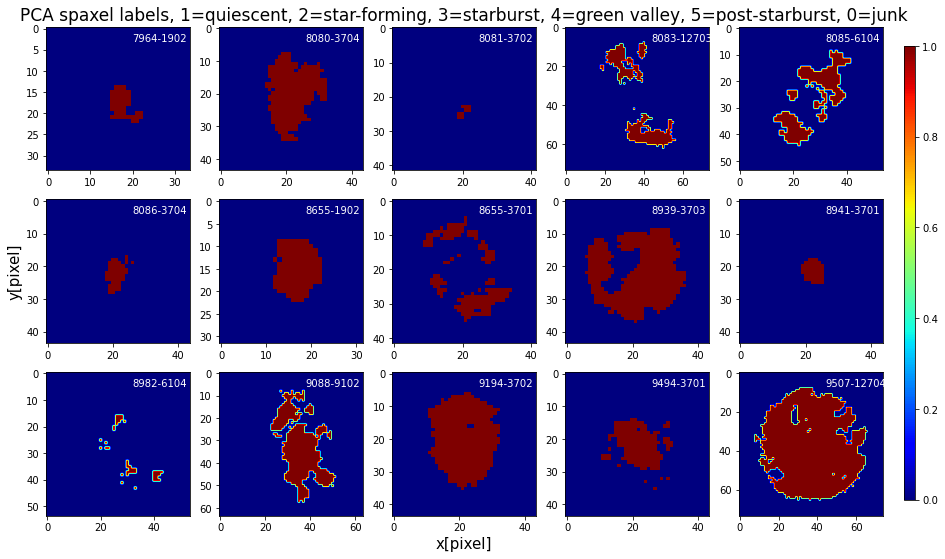

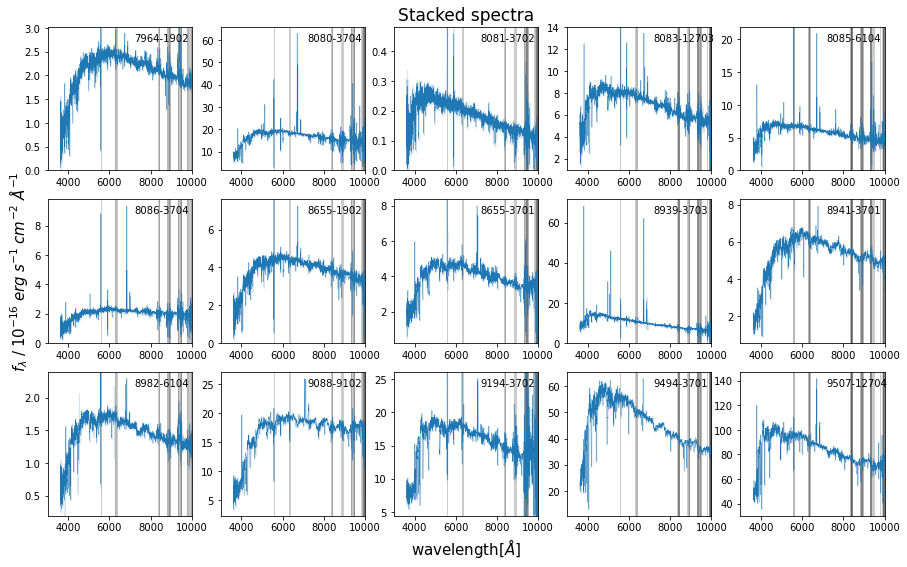

In [123]:
# option 5
plot_option(binned=True, SNR_threshold=None, qualmask_choice='PCA')

Moving from option 1 to 5 would include more spaxels in the total sum, but juding from simple eyeballing the stacked spectra, they don't seem to change that much. This is also true comparing the previous set of spectra produced which was not masked using PCA labels.